### Running baseline models

In [2]:
# necessary modules
import pandas as pd
import shap
import torch

from DataPreprocessing.preprocessing_function import preprocess_data, preprocess_no_split
from baseline_models import train_multinomial_logistic_regression, train_decision_tree

### JFK Baseline Models

In [3]:
# import dataset
merged_jfk_df = pd.read_csv('data/complete/JFK_final_df.csv')

# preprocessing
X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk = preprocess_data(merged_jfk_df)

In [ ]:
jfk_MLR_model, jfk_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_jfk, Y_train_torch_jfk, X_test_torch_jfk, Y_test_torch_jfk)

In [ ]:
jfk_DT_model, jfk_metrics_DT = train_decision_tree(X_train_torch_jfk, X_test_torch_jfk, Y_train_torch_jfk, Y_test_torch_jfk, feature_names_jfk)

### MIA Baseline Models

In [4]:
# import dataset
merged_mia_df = pd.read_csv('data/complete/MIA_final_df.csv')

# preprocessing
X_train_torch_mia, X_test_torch_mia, Y_train_torch_mia, Y_test_torch_mia, feature_names_mia = preprocess_data(merged_mia_df)

Epoch [10/100], Loss: 2.6679, Accuracy: 0.0963
Epoch [20/100], Loss: 2.5988, Accuracy: 0.1335
Epoch [30/100], Loss: 2.5308, Accuracy: 0.1791
Epoch [40/100], Loss: 2.4640, Accuracy: 0.2308
Epoch [50/100], Loss: 2.3985, Accuracy: 0.2869
Epoch [60/100], Loss: 2.3342, Accuracy: 0.3431
Epoch [70/100], Loss: 2.2713, Accuracy: 0.3984
Epoch [80/100], Loss: 2.2099, Accuracy: 0.4508
Epoch [90/100], Loss: 2.1498, Accuracy: 0.5003
Epoch [100/100], Loss: 2.0913, Accuracy: 0.5467

Training Set Metrics:
Accuracy: 0.5513
Precision: 0.7384
Recall: 0.5513
F1: 0.6292

Test Set Metrics:
Accuracy: 0.5771
Precision: 0.7585
Recall: 0.5771
F1: 0.6533


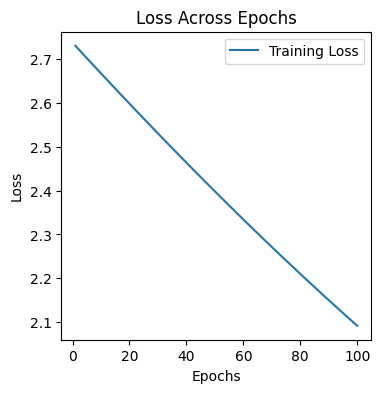

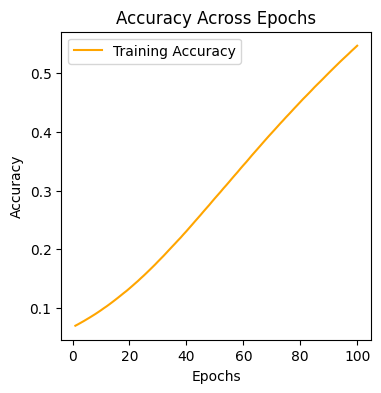

In [14]:
mia_MLR_model, mia_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_mia, Y_train_torch_mia, X_test_torch_mia, Y_test_torch_mia)

In [ ]:
mia_DT_model, mia_metrics_DT = train_decision_tree(X_train_torch_mia, X_test_torch_mia, Y_train_torch_mia, Y_test_torch_mia, feature_names_mia)

### LAX models

In [5]:
# import dataset
merged_lax_df = pd.read_csv('data/complete/LAX_final_df.csv')

# preprocessing
X_train_torch_lax, X_test_torch_lax, Y_train_torch_lax, Y_test_torch_lax, feature_names_lax = preprocess_data(merged_lax_df)

Epoch [10/100], Loss: 2.5721, Accuracy: 0.1431
Epoch [20/100], Loss: 2.5021, Accuracy: 0.1892
Epoch [30/100], Loss: 2.4334, Accuracy: 0.2399
Epoch [40/100], Loss: 2.3659, Accuracy: 0.2955
Epoch [50/100], Loss: 2.2999, Accuracy: 0.3571
Epoch [60/100], Loss: 2.2353, Accuracy: 0.4246
Epoch [70/100], Loss: 2.1721, Accuracy: 0.4916
Epoch [80/100], Loss: 2.1104, Accuracy: 0.5522
Epoch [90/100], Loss: 2.0503, Accuracy: 0.6032
Epoch [100/100], Loss: 1.9918, Accuracy: 0.6462

Training Set Metrics:
Accuracy: 0.6501
Precision: 0.7822
Recall: 0.6501
F1: 0.7091

Test Set Metrics:
Accuracy: 0.6351
Precision: 0.7541
Recall: 0.6351
F1: 0.6884


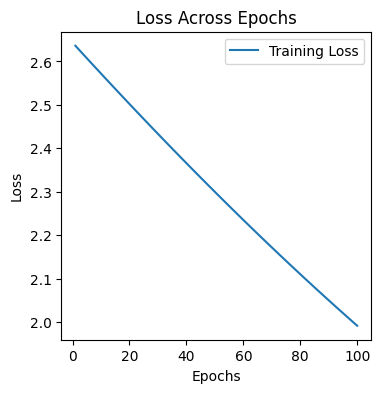

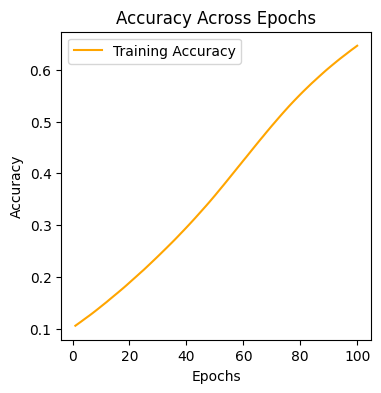

In [7]:
lax_MLR_model, lax_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_lax, Y_train_torch_lax, X_test_torch_lax, Y_test_torch_lax)

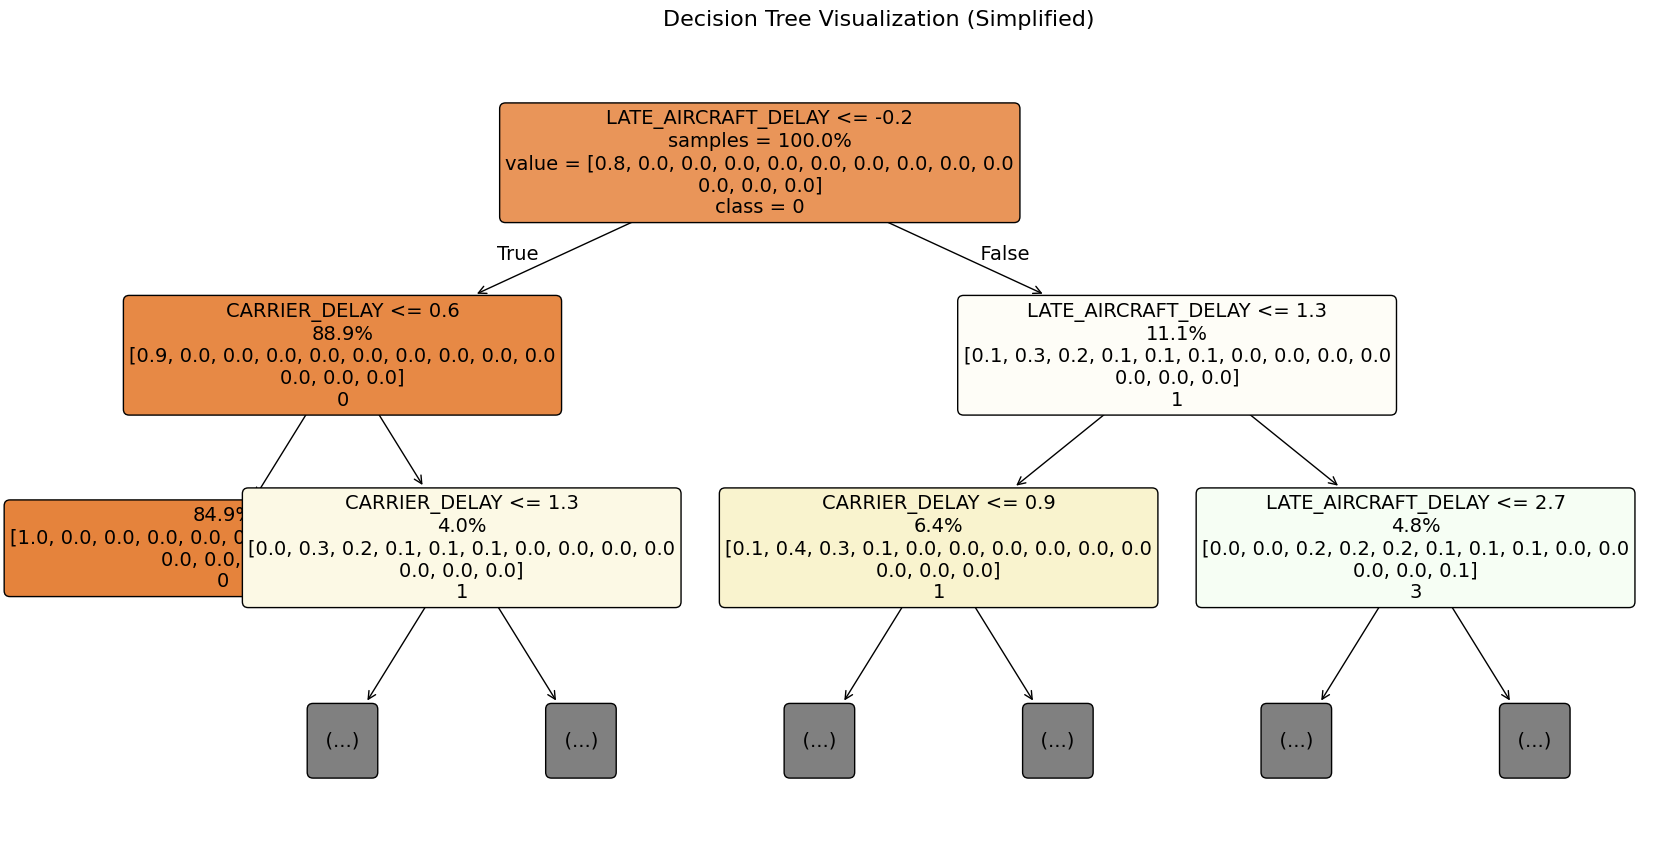

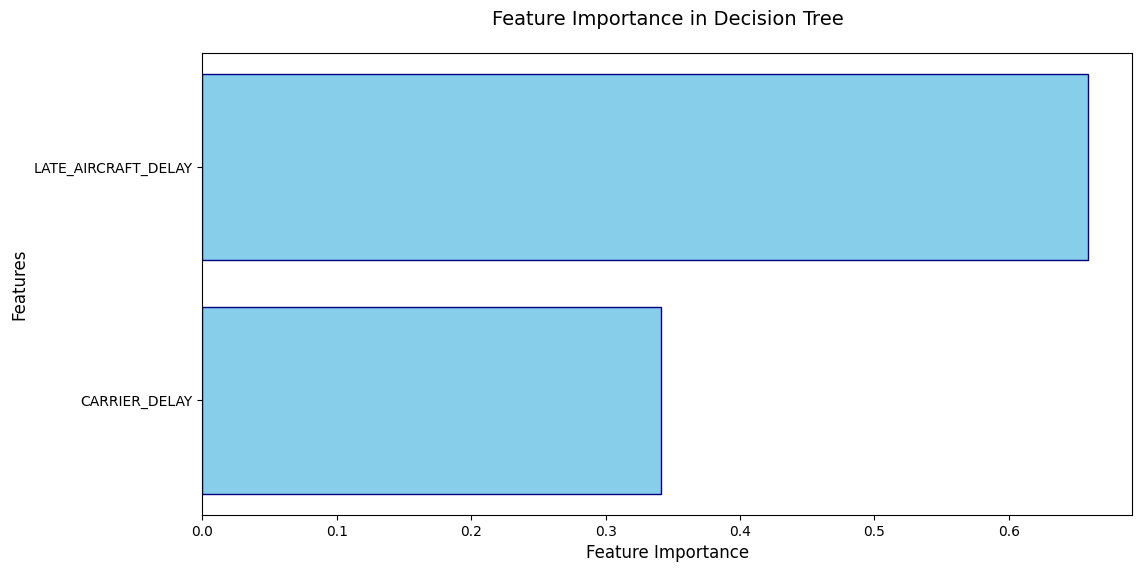

c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mhair\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training Set Metrics:
Accuracy: 0.9104
Precision: 0.8962
Recall: 0.9104
F1: 0.8999

Test Set Metrics:
Accuracy: 0.8868
Precision: 0.8683
Recall: 0.8868
F1: 0.8732


In [8]:
lax_DT_model, lax_metrics_DT = train_decision_tree(X_train_torch_lax, X_test_torch_lax, Y_train_torch_lax, Y_test_torch_lax, feature_names_lax)

### EWR Baseline Models

In [6]:
# import dataset
merged_ewr_df = pd.read_csv('data/complete/EWR_final_df.csv')

# preprocessing
X_train_torch_ewr, X_test_torch_ewr, Y_train_torch_ewr, Y_test_torch_ewr, feature_names_ewr = preprocess_data(merged_ewr_df)

In [ ]:
ewr_MLR_model, ewr_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_ewr, Y_train_torch_ewr, X_test_torch_ewr, Y_test_torch_ewr)

In [ ]:
ewr_DT_model, ewr_metrics_DT = train_decision_tree(X_train_torch_ewr, X_test_torch_ewr, Y_train_torch_ewr, Y_test_torch_ewr, feature_names_ewr)

### ORD Baseline Models

In [7]:
# import dataset
merged_ord_df = pd.read_csv('data/complete/ORD_final_df.csv')

# preprocessing
X_train_torch_ord, X_test_torch_ord, Y_train_torch_ord, Y_test_torch_ord, feature_names_ord = preprocess_data(merged_ord_df)

Epoch [10/100], Loss: 2.6465, Accuracy: 0.0900
Epoch [20/100], Loss: 2.5804, Accuracy: 0.1258
Epoch [30/100], Loss: 2.5154, Accuracy: 0.1681
Epoch [40/100], Loss: 2.4517, Accuracy: 0.2165
Epoch [50/100], Loss: 2.3891, Accuracy: 0.2700
Epoch [60/100], Loss: 2.3279, Accuracy: 0.3279
Epoch [70/100], Loss: 2.2680, Accuracy: 0.3899
Epoch [80/100], Loss: 2.2095, Accuracy: 0.4523
Epoch [90/100], Loss: 2.1524, Accuracy: 0.5093
Epoch [100/100], Loss: 2.0967, Accuracy: 0.5560

Training Set Metrics:
Accuracy: 0.5601
Precision: 0.7153
Recall: 0.5601
F1: 0.6267

Test Set Metrics:
Accuracy: 0.5807
Precision: 0.7574
Recall: 0.5807
F1: 0.6556


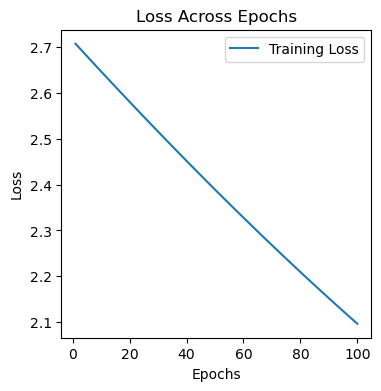

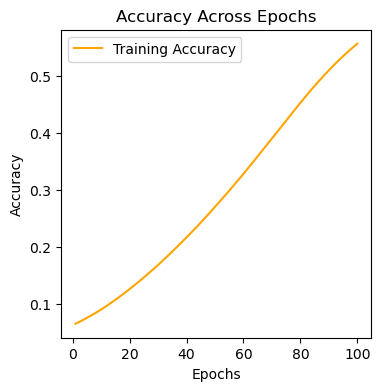

In [11]:
ord_MLR_model, ord_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_ord, Y_train_torch_ord, X_test_torch_ord, Y_test_torch_ord)

In [ ]:
ord_DT_model, ord_metrics_DT = train_decision_tree(X_train_torch_ord, X_test_torch_ord, Y_train_torch_ord, Y_test_torch_ord, feature_names_ord)

### Running models using all airports

In [7]:
# Concatenate the datasets - we will test on ORD
combined_df = pd.concat([merged_jfk_df, merged_ewr_df, merged_lax_df, merged_mia_df])
combined_df = combined_df.dropna()

# Sort the combined dataset sequentially
combined_df = combined_df.sort_values(by='DEP_DATE_TIME')

In [9]:
# Preprocessing data 
X_train_torch_comb, Y_train_torch_comb, scaler, preprocessor = preprocess_no_split(combined_df, 'train') # First 4 airports are the training data
X_test_torch_comb, Y_test_torch_comb, _, _ = preprocess_no_split(merged_ord_df, 'test', scaler, preprocessor) # The last airport is the test data

/opt/anaconda3/envs/mlp/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Epoch [10/100], Loss: 2.6708, Accuracy: 0.0737
Epoch [20/100], Loss: 2.6010, Accuracy: 0.1114
Epoch [30/100], Loss: 2.5324, Accuracy: 0.1612
Epoch [40/100], Loss: 2.4650, Accuracy: 0.2193
Epoch [50/100], Loss: 2.3989, Accuracy: 0.2832
Epoch [60/100], Loss: 2.3342, Accuracy: 0.3504
Epoch [70/100], Loss: 2.2708, Accuracy: 0.4180
Epoch [80/100], Loss: 2.2089, Accuracy: 0.4850
Epoch [90/100], Loss: 2.1485, Accuracy: 0.5482
Epoch [100/100], Loss: 2.0896, Accuracy: 0.6034

Training Set Metrics:
Accuracy: 0.6083
Precision: 0.7460
Recall: 0.6083
F1: 0.6686

Test Set Metrics:
Accuracy: 0.5688
Precision: 0.6971
Recall: 0.5688
F1: 0.6245


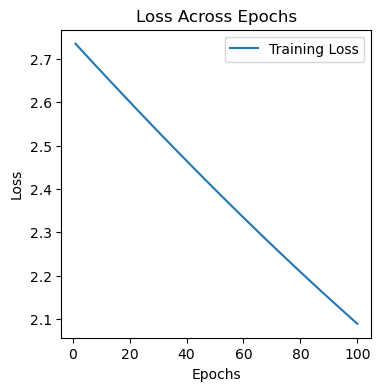

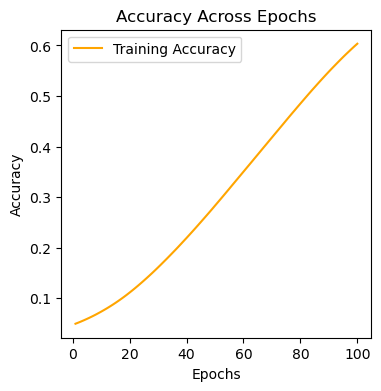

In [10]:
comb_MLR_model, comb_metrics_MLR = train_multinomial_logistic_regression(X_train_torch_comb, Y_train_torch_comb, X_test_torch_comb, Y_test_torch_comb)

fold: 1
training data preprocessed


/opt/anaconda3/envs/mlp/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


data preprocessed
Epoch [10/100], Loss: 2.5957, Accuracy: 0.1269
Epoch [20/100], Loss: 2.5288, Accuracy: 0.1714
Epoch [30/100], Loss: 2.4631, Accuracy: 0.2261
Epoch [40/100], Loss: 2.3986, Accuracy: 0.2898
Epoch [50/100], Loss: 2.3354, Accuracy: 0.3542
Epoch [60/100], Loss: 2.2735, Accuracy: 0.4232
Epoch [70/100], Loss: 2.2130, Accuracy: 0.4952
Epoch [80/100], Loss: 2.1540, Accuracy: 0.5590
Epoch [90/100], Loss: 2.0964, Accuracy: 0.6134
Epoch [100/100], Loss: 2.0404, Accuracy: 0.6575

Training Set Metrics:
Accuracy: 0.6613
Precision: 0.7324
Recall: 0.6613
F1: 0.6941

Test Set Metrics:
Accuracy: 0.7608
Precision: 0.7602
Recall: 0.7608
F1: 0.7598


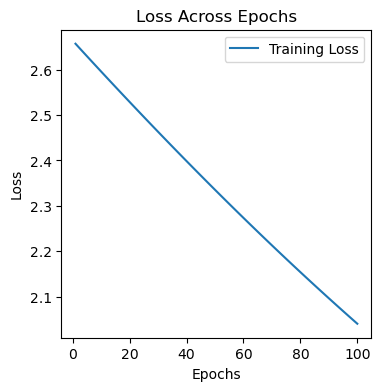

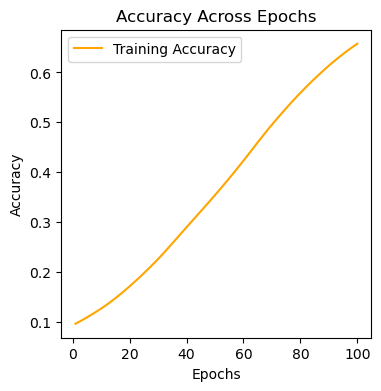

KeyError: 'accuracy'

In [8]:
# Perform 5-fold cross-validation
airports = ['JFK', 'EWR', 'LAX', 'MIA', 'ORD']
airport_data_dict = {
    'JFK': merged_jfk_df,
    'EWR': merged_ewr_df,
    'LAX': merged_lax_df,
    'MIA': merged_mia_df,
    'ORD': merged_ord_df
}
val_metrics = []

for i, val_airport in enumerate(airports):

    print(f"fold: {i+1}")

    # Combine the train data (use all airports except the validation one)
    train_airports = [airport for j, airport in enumerate(airports) if j != i]
    
    # Get the training and validation data
    train_data = pd.concat([airport_data_dict[airport] for airport in train_airports])
    train_data = train_data.sort_values(by='DEP_DATE_TIME').dropna()
    val_data = airport_data_dict[val_airport]

    # Preprocess the data (preprocessing should use the same scaler and preprocessor for both training and validation)
    X_train_torch, Y_train_torch, scaler, preprocessor = preprocess_no_split(train_data, 'train')
    X_val_torch, Y_val_torch, _, _ = preprocess_no_split(val_data, 'test', scaler, preprocessor)

    print('data preprocessed')

    # Initialize model and optimizer
    model, metrics = train_multinomial_logistic_regression(X_train_torch, Y_train_torch, X_val_torch, Y_val_torch)

    val_metrics.append(metrics)


In [12]:
comb_DT_model, comb_metrics_DT = train_decision_tree(X_train_torch_comb, X_test_torch_comb, Y_train_torch_comb, Y_test_torch_comb, feature_names_ord)

ValueError: Shape of passed values is (4108067, 197), indices imply (4108067, 208)

### SHAP analysis

In [ ]:
#SHAP DT model

shap.initjs() # Initialize the SHAP JavaScript library

# Convert PyTorch tensor to DataFrame, with column names
X_test_df = pd.DataFrame(X_test_torch_jfk.numpy(), columns=feature_names_jfk)

# Use TreeExplainer with the actual DecisionTreeClassifier inside your wrapper
explainer = shap.TreeExplainer(jfk_DT_model.model)
shap_values = explainer.shap_values(X_test_df)

# Mean SHAP plot
shap.summary_plot(shap_values, X_test_df)

# look at what the table looks like, compare with documentation (run it myself to see what their data looks like)

In [ ]:
#SHAP MLR model w/ KernelExplainer 

# Convert PyTorch tensor to DataFrame, with column names
X_test_df = pd.DataFrame(X_test_torch_jfk.numpy(), columns=feature_names_jfk)

# Create the SHAP explainer
explainer = shap.KernelExplainer(jfk_MLR_model, X_test_torch_jfk) # neither passing numpy df or tensors seems to work
shap_values = explainer.shap_values(X_test_df)

# Mean SHAP plot
shap.summary_plot(shap_values, X_test_df)

In [ ]:
#SHAP MLR model w/ DeepExplainer 

# Convert PyTorch tensor to DataFrame, with column names
X_test_df = pd.DataFrame(X_test_torch_jfk.numpy(), columns=feature_names_jfk)

# Create the SHAP explainer
explainer = shap.DeepExplainer(jfk_MLR_model, X_test_torch_jfk) 
shap_values = explainer.shap_values(X_test_torch_jfk) # This bit runs infinitely?

# Mean SHAP plot
# shap.summary_plot(shap_values, X_test_torch_jfk)

In [ ]:
#SHAP MLR model w/ LinearExplainer 

explainer = shap.LinearExplainer(jfk_MLR_model, X_test_df)
shap_values = explainer.shap_values(X_test_df)

# Mean SHAP plot
# shap.summary_plot(shap_values, X_test_torch_jfk)

to do:
- run baseline models on other datasets
- finalise tables and graphs for baseline models